# Packages

In [1422]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from covid19model.models.base import BaseModel
from covid19model.data.utils import construct_initN
from covid19model.models.time_dependant_parameter_fncs import ramp_fun
from covid19model.models.time_dependant_parameter_fncs import make_seasonality_function
from covid19model.data.sciensano import get_sciensano_COVID19_data
import csv
from csv import DictReader

# Data

In [1423]:
abs_dir = os.getcwd()
rel_dir = '../../data/interim/QALY_model/postponement_non_covid_care/UZG/'
file_name = 'MZG_residence_times.csv'

types_dict = {'APR_MDC_key': str, 'age_group': str, 'stay_type':str}
residence_times = pd.read_csv(os.path.join(abs_dir,rel_dir,file_name),index_col=[0,1,2],dtype=types_dict).squeeze()
mean_residence_times = residence_times.groupby(by=['APR_MDC_key']).mean()

file_name = 'MZG_baseline.csv'
types_dict = {'APR_MDC_key': str, 'week_number': int, 'day_number':int}
hospitalization_baseline = pd.read_csv(os.path.join(abs_dir,rel_dir,file_name),index_col=[0,1,2,3],dtype=types_dict).squeeze()
hospitalization_baseline = hospitalization_baseline.groupby(['APR_MDC_key','week_number','day_number']).median()

file_name = 'MZG_Hospitalizations_per_day.csv'
types_dict = {'APR_MDC_key': str}
hospitalizations_per_day = pd.read_csv(os.path.join(abs_dir,rel_dir,file_name),index_col=[0,1],dtype=types_dict).squeeze()

file_name = 'MZG_covid_hospitalizations_per_day.csv'
types_dict = {'APR_MDC_key': str}
covid_hospitalizations_per_day = pd.read_csv(os.path.join(abs_dir,rel_dir,file_name),index_col=[0],dtype=types_dict).squeeze()
covid_hospitalizations_per_day -= 4
covid_hospitalizations_per_day[np.where(covid_hospitalizations_per_day<0)[0]]=0

file_name = '2020_2021_normalized.csv'
types_dict = {'APR_MDC_key': str}
hospitalizations_normalized = pd.read_csv(os.path.join(abs_dir,rel_dir,file_name),index_col=[0,1],dtype=types_dict).squeeze()

covid_data, _ , _ , _ = get_sciensano_COVID19_data(update=False)
covid_H_in = covid_data['H_in'].loc[:,40000].ewm(7).mean()
covid_H_tot = covid_data['H_tot'].loc[:,40000].ewm(7).mean()

MDC_dict={}
file_name = 'MDC_dict.csv'
with open(os.path.join(abs_dir,rel_dir,file_name), mode='r') as f:
    csv_reader = csv.reader(f, delimiter=',')
    for row in csv_reader:
        MDC_dict.update({row[0]:row[1]})

MDC_keys = hospitalization_baseline.index.get_level_values(0).unique().values
MDC_keys = np.append(MDC_keys,'covid')
MDC_dict.update({'covid':'covid'})
mean_residence_times['covid']=10


# Define model and functions

In [1424]:
class postponed_healthcare_model(BaseModel):
    """
    Test model for postponed health_care using a waiting queue before hospitalization
    """
    
    state_names = ['H','E']
    parameter_names = ['covid','alpha','beta','gamma','Ki','Kp']
    parameters_stratified_names = []
    stratification = ['MDC_keys']
    coordinates = [None]
    
    @staticmethod
    def integrate(t,H,E,covid,alpha,beta,gamma, Ki, Kp, MDC_keys):

        epsilon = H-1
        dE = epsilon - gamma*E
        u = Kp * epsilon + Ki * E
        dH = alpha*covid + beta*u
        
        return dH, dE

In [1425]:
def hypothetical_covid_peak(t, states, param,MDC_keys,start_peak,end_peak,peak_amplitude):
    start_peak = pd.to_datetime(start_peak)
    end_peak = pd.to_datetime(end_peak)
    l_days = end_peak-start_peak
    l = l_days/pd.Timedelta(days=1)

    if t <= start_peak:
        covid_H = 0
    elif start_peak < t <= start_peak+l_days/2:
        covid_H = ramp_fun(0, peak_amplitude, t, start_peak, l/2)
    elif start_peak+l_days/2 < t <= end_peak:
        covid_H = ramp_fun(peak_amplitude, 0, t, start_peak+l_days/2, l/2)
    else:
        covid_H=0

    return covid_H


In [1426]:
def get_covid_hospitalizations(t,states,param,tau):
    t = pd.to_datetime(t).round(freq='D')-pd.Timedelta(days=tau)
    try:
        covid_H = covid_H_in.loc[t]
    except:
        covid_H = 0
    return covid_H

In [1427]:
def get_covid_dH(t,states,param,tau):
    t = pd.to_datetime(t).round(freq='D')-pd.Timedelta(days=tau)
    try:
        covid_H_next = covid_H_tot.loc[t+pd.Timedelta(days=1)]
    except:
        covid_H_next = 0
    
    try:
        covid_H = covid_H_tot.loc[t]
    except:
        covid_H = 0

    return covid_H_next - covid_H

In [1428]:
def alpha_func(t,states,param):
    if t < pd.to_datetime('2020-08-06'):
        alpha = np.ones(len(MDC_classes))*-0.0006
        alpha[np.where(MDC_classes=='04')]=0.001
    else:
        alpha = np.ones(len(MDC_classes))*-0.0003
        alpha[np.where(MDC_classes=='04')]=0.001
    return alpha

In [1429]:
def alpha2_func(t,states,param):
    if t < pd.to_datetime('2020-08-06'):
        alpha = np.ones(len(MDC_classes))*-0.001
        alpha[np.where(MDC_classes=='04')]=0.001
    else:
        alpha = np.ones(len(MDC_classes))*-0.0005
        alpha[np.where(MDC_classes=='04')]=0.001
    return alpha

In [1430]:
def gamma_func(t,states,param):
    if t < pd.to_datetime('2020-08-06'):
        gamma = np.ones(len(MDC_classes))*0.06
        gamma[np.where(MDC_classes=='04')]=0.06
    else:
        gamma = np.ones(len(MDC_classes))*0.02
        gamma[np.where(MDC_classes=='04')]=0.06
    return gamma

# Parameters

In [1431]:
#set start and end date of sim
start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2021-12-31')
sim_len = (end_date - start_date)/pd.Timedelta(days=1)

# Define MDC classes to model
MDC_classes = np.array(['04','05'])

# Define model parameters, initial states and coordinates
alpha = np.ones(len(MDC_classes))*-0.0006
alpha[np.where(MDC_classes=='04')]=0.002
beta = np.ones(len(MDC_classes))*-0.05
beta[np.where(MDC_classes=='04')]=-0.09
Kp = np.ones(len(MDC_classes))*0.1
Ki = np.ones(len(MDC_classes))*0.04
gamma = np.ones(len(MDC_classes))*0.06
gamma[np.where(MDC_classes=='04')]=0.06
epsilon = 0
covid = 0
params={'alpha':alpha, 'beta':beta,'gamma':gamma,'Kp':Kp,'Ki':Ki,'covid':covid,'MDC_keys':MDC_classes}

# parameters that control the covid peak
#start_peak = '2021-01-05'
#end_peak = '2021-03-01'
#peak_amplitude = 10
#params.update({'start_peak':start_peak,'end_peak':end_peak,'peak_amplitude':peak_amplitude})

tau = -10
params.update({'tau':tau})


In [1432]:
#set start and end date of sim
start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2021-12-31')
sim_len = (end_date - start_date)/pd.Timedelta(days=1)

# Define MDC classes to model
MDC_classes = np.array(['04','05'])

# Define model parameters, initial states and coordinates
alpha = np.ones(len(MDC_classes))*-0.001
alpha[np.where(MDC_classes=='04')]=0.002
beta = np.ones(len(MDC_classes))*-0.01
beta[np.where(MDC_classes=='04')]=-0
Kp = np.ones(len(MDC_classes))*0.1
Ki = np.ones(len(MDC_classes))*0.04
gamma = np.ones(len(MDC_classes))*0.06
gamma[np.where(MDC_classes=='04')]=0.06
epsilon = 0
covid = 0
params2={'alpha':alpha, 'beta':beta,'gamma':gamma,'Kp':Kp,'Ki':Ki,'covid':covid,'MDC_keys':MDC_classes}

# parameters that control the covid peak
#start_peak = '2021-01-05'
#end_peak = '2021-03-01'
#peak_amplitude = 10
#params.update({'start_peak':start_peak,'end_peak':end_peak,'peak_amplitude':peak_amplitude})

tau = -10
params2.update({'tau':tau})


# Initialize model

In [1433]:
#covid_data = covid_data.reindex(pd.date_range(start_date,end_date),fill_value=0)

In [1434]:
init_states = {'H':np.ones(len(MDC_classes)),'E':np.zeros(len(MDC_classes))}
coordinates=[MDC_classes,]
# Initialize model
model = postponed_healthcare_model(init_states,params,coordinates,time_dependent_parameters={'covid': get_covid_hospitalizations,'alpha':alpha_func,'gamma':gamma_func})
model2 = postponed_healthcare_model(init_states,params2,coordinates,time_dependent_parameters={'covid': get_covid_dH,'alpha':alpha2_func})

# Simulate model

In [1435]:
out = model.sim(sim_len,start_date=start_date)
out2 = model2.sim(sim_len,start_date=start_date)

# Plots

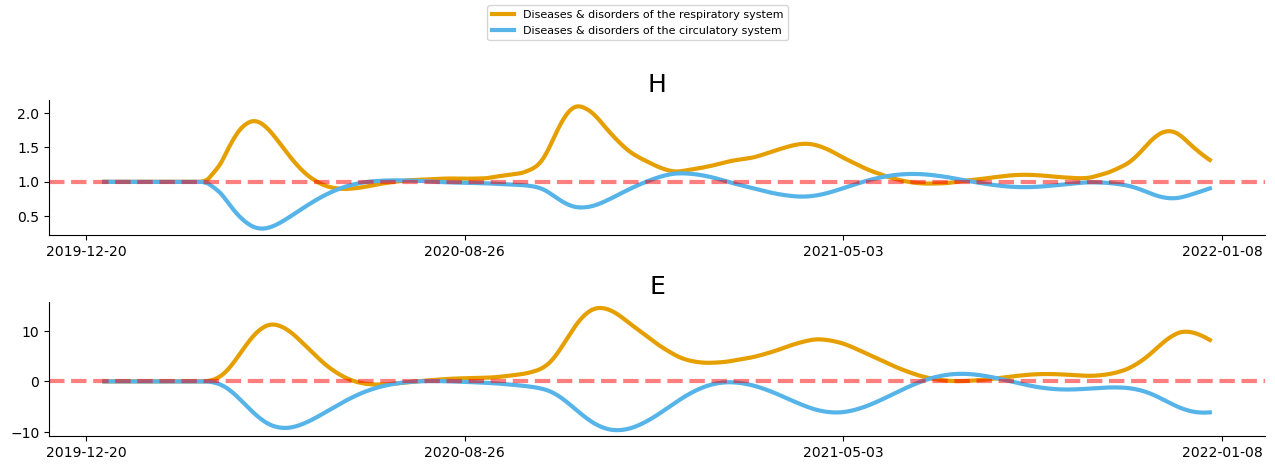

In [1436]:
fig,axs = plt.subplots(2,1)
time = out['time']
#for idx,state in enumerate(model.state_names):
for idx,state in enumerate(['H','E']):
    for disease in MDC_classes:
        axs[idx].plot(time,out.sel(MDC_keys=disease)[state],label=MDC_dict[disease])
        axs[idx].set_title(state)
        axs[idx].xaxis.set_major_locator(plt.MaxNLocator(4))
        axs[idx].grid(False)
        axs[idx].tick_params(axis='both', which='major', labelsize=10)
        axs[idx].tick_params(axis='both', which='minor', labelsize=8)

axs[0].axhline(y = 1, color = 'r', linestyle = 'dashed', alpha=0.5) 
axs[1].axhline(y = 0, color = 'r', linestyle = 'dashed', alpha=0.5) 

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=2,
                    top=0.8,
                    wspace=0.5,
                    hspace=0.5)
handles, labels = axs[idx].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',fontsize=8)
plt.show()

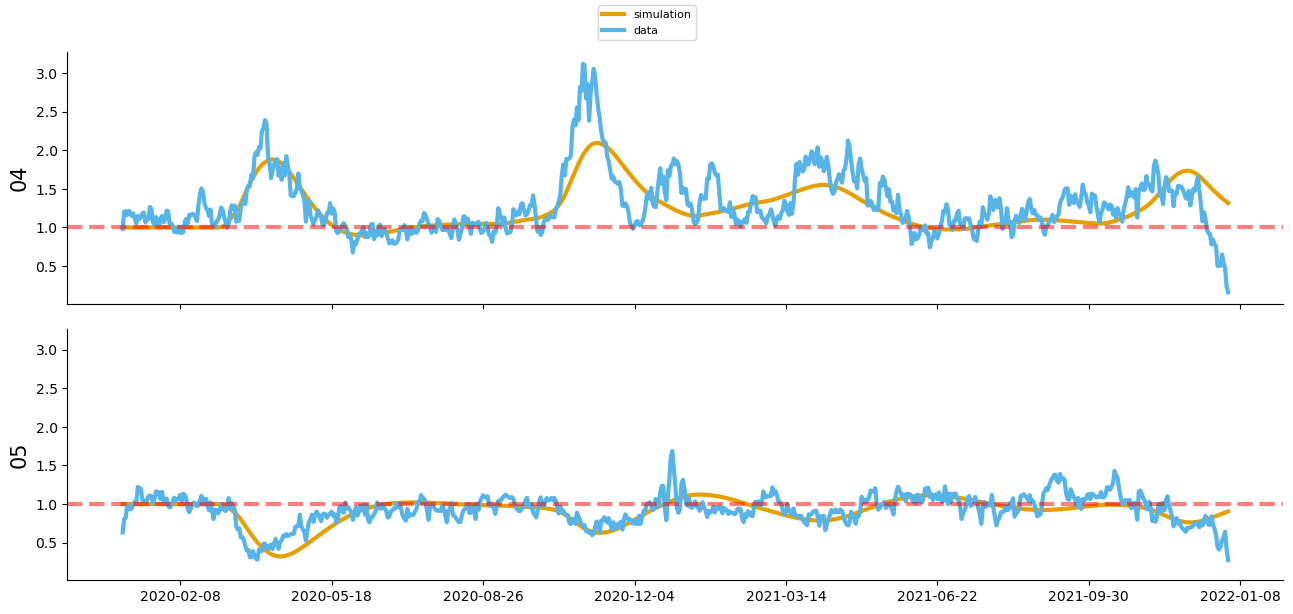

In [1437]:
plot_classes = ['04','05']
time = out['time'].values
index = pd.MultiIndex.from_product([plot_classes,pd.to_datetime(time).strftime('%Y-%m-%d')],names=['APR_MDC_key','date'])
data = hospitalizations_normalized.copy()
data = data.reindex(index=index)

fig,axs = plt.subplots(len(plot_classes),sharex=True,sharey=True)
axs = axs.reshape(-1)

for idx,disease in enumerate(plot_classes):
    axs[idx].plot(time,out.sel(MDC_keys=disease)['H'],label='simulation')
    axs[idx].plot(time,data.loc[disease]['median'], label='data')
    axs[idx].set_ylabel(disease)
    axs[idx].xaxis.set_major_locator(plt.MaxNLocator(10))
    axs[idx].grid(False)
    axs[idx].tick_params(axis='both', which='major', labelsize=10)
    axs[idx].tick_params(axis='both', which='minor', labelsize=8)
    #axs[idx].tick_params('x', labelbottom=False)

handles, labels = axs[idx].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',fontsize=8)

for idx in range(len(axs)):
    axs[idx].axhline(y = 1, color = 'r', linestyle = 'dashed', alpha=0.5) 

plt.subplots_adjust(left=0.1,
                    bottom=-0.2,
                    right=2,
                    top=0.9,
                    wspace=0.1,
                    hspace=0.1)

plt.show()

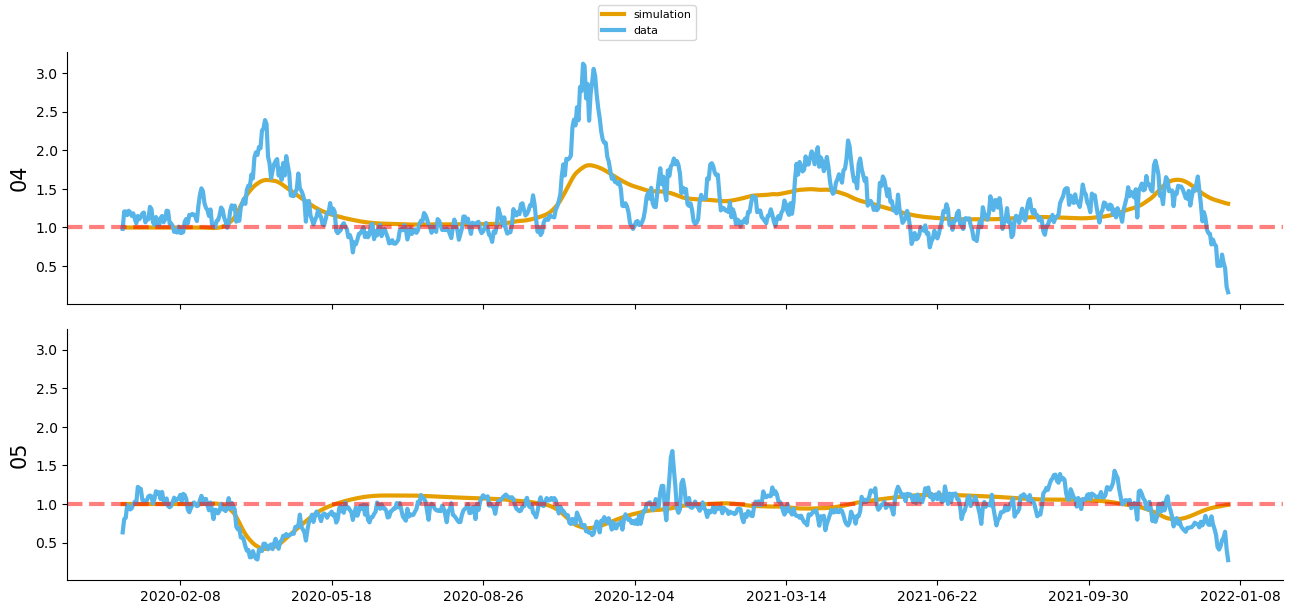

In [1438]:
plot_classes = ['04','05']
time = out['time'].values
index = pd.MultiIndex.from_product([plot_classes,pd.to_datetime(time).strftime('%Y-%m-%d')],names=['APR_MDC_key','date'])
data = hospitalizations_normalized.copy()
data = data.reindex(index=index)

fig,axs = plt.subplots(len(plot_classes),sharex=True,sharey=True)
axs = axs.reshape(-1)

for idx,disease in enumerate(plot_classes):
    axs[idx].plot(time,out2.sel(MDC_keys=disease)['H'],label='simulation')
    axs[idx].plot(time,data.loc[disease]['median'], label='data')
    axs[idx].set_ylabel(disease)
    axs[idx].xaxis.set_major_locator(plt.MaxNLocator(10))
    axs[idx].grid(False)
    axs[idx].tick_params(axis='both', which='major', labelsize=10)
    axs[idx].tick_params(axis='both', which='minor', labelsize=8)
    #axs[idx].tick_params('x', labelbottom=False)

handles, labels = axs[idx].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',fontsize=8)

for idx in range(len(axs)):
    axs[idx].axhline(y = 1, color = 'r', linestyle = 'dashed', alpha=0.5) 

plt.subplots_adjust(left=0.1,
                    bottom=-0.2,
                    right=2,
                    top=0.9,
                    wspace=0.1,
                    hspace=0.1)

plt.show()

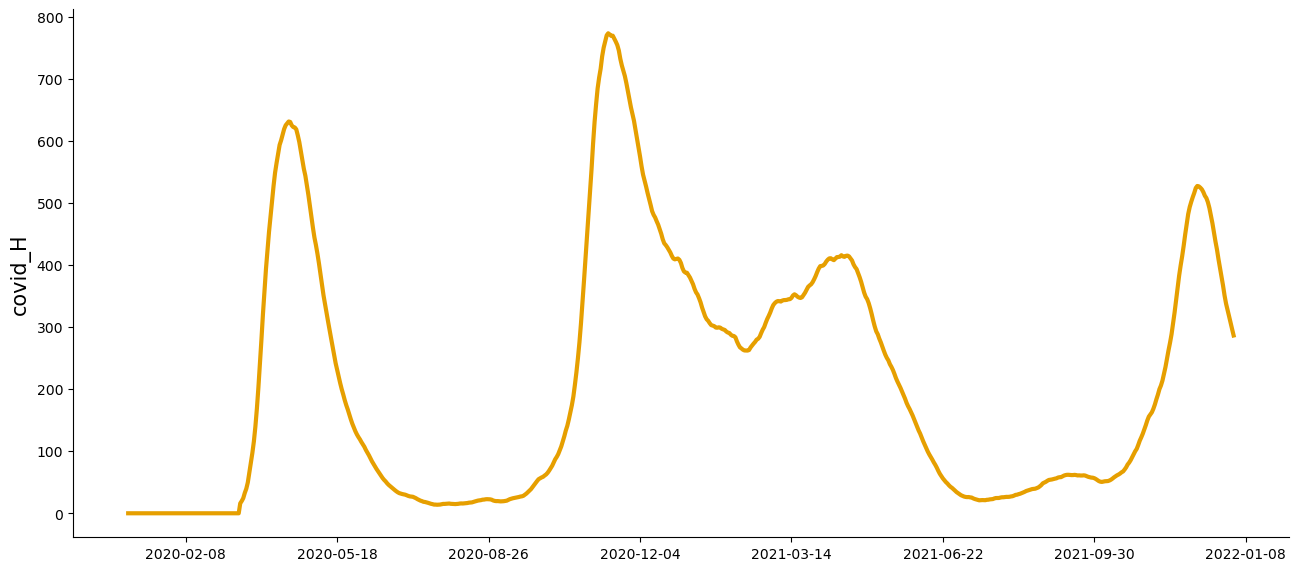

In [1439]:
covid_H_tot = covid_H_tot.reindex(pd.date_range(start_date,end_date),fill_value=0)
fig,ax = plt.subplots()
ax.plot(time,covid_H_tot)
ax.set_ylabel('covid_H')
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.grid(False)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=8)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=2,
                    top=1.2,
                    wspace=0.1,
                    hspace=0.1)
plt.show()